In [1]:
import numpy as np
from scipy import constants
import pandas as pd
import matplotlib.pyplot as plt
from tweezer_functions import * 
from IonChainTools import *
from scipy.optimize import fsolve

#Constants in SI units
eps0 = constants.epsilon_0 
m = 39.9626*constants.atomic_mass
c = constants.c
e = constants.e
hbar = constants.hbar
pi = np.pi

# setting up parameters that we're not changing
NA = 0.1
tweezer_wavelength = 532e-9
omega_tweezer = 2*pi*c/tweezer_wavelength
df = pd.read_csv("S_P_only.csv",sep = ",",encoding = "UTF-8")
lambdares = np.array(df["wavelength (nm)"])*1e-9
omega_res = 2*pi*c/lambdares
linewidths = np.array(df["A_ki (s^-1)"])
lifetimes = linewidths

In [2]:
P_opt = np.linspace(0,1,100) #going from 0 to 1 W 
w_rf_r =1* 1e6
w_rf_a = w_rf_r / 3
omega_rf_axial = w_rf_a * 2 * pi
displacement = 1e-9
beam_waist_fixed =1e-6

#print(P_opt)
N = 3
tweezed_ions = [0,1]
ionspacing = ion_spacing(N,omega_rf_axial)
# Initialize a list to store data: each element corresponds to a power
Modes = []

# Iterate over optical powers
for j in range(len(P_opt)):
    # Calculate tweezer radial frequency and equilibrium positions
    omega_tw_radial = 2 * np.pi * tweezer_optical_potential_to_trap_frequency(
        tweezer_wavelength, linewidths, omega_res, P_opt[j], beam_waist_fixed, m
    )[0]
    ueq = ion_spacing_tweezers(
        pot_derivative_with_tweeze, ionspacing, omega_rf_axial, omega_tw_radial, tweezed_ions, displacement
    )[0]

    # Get modes for the tweezed system (both ions tweezed simultaneously)
    mode_data = physical_params_to_axial_mode_vectors(
        N, ueq, tweezed_ions, tweezer_wavelength, linewidths, omega_res, w_rf_a, w_rf_r, P_opt[j], beam_waist_fixed, m
    )

    # Save both frequencies and mode vectors
    Modes.append({
        "frequencies": [rm[0] for rm in mode_data],  # Extract frequencies
        "vectors": [rm[1] for rm in mode_data]       # Extract mode vectors
    })

# Print the structure of Modes for verification
print(f"Modes structure (frequencies and vectors per power):")
for idx, mode_entry in enumerate(Modes[:5]):  # Display the first 5 power entries
    print(f"P_opt[{idx}] Frequencies: {mode_entry['frequencies']}")
    print(f"P_opt[{idx}] Vectors: {mode_entry['vectors']}")

Modes structure (frequencies and vectors per power):
P_opt[0] Frequencies: [53051.647697298635, 474380.33216567914, 732221.1487363158]
P_opt[0] Vectors: [array([0.57735027, 0.57735027, 0.57735027]), array([ 7.07106781e-01, -6.13252440e-14, -7.07106781e-01]), array([-0.40824829,  0.81649658, -0.40824829])]
P_opt[1] Frequencies: [97930.39015261338, 479833.65771999105, 738086.092119491]
P_opt[1] Vectors: [array([0.56561167, 0.57344779, 0.59265595]), array([ 0.71421263,  0.01866337, -0.69967993]), array([-0.41229087,  0.8190295 , -0.39900743])]
P_opt[2] Frequencies: [127195.61722331183, 485341.85218870355, 743955.0614793149]
P_opt[2] Vectors: [array([0.55345852, 0.5691691 , 0.60805443]), array([ 0.72145167,  0.03716944, -0.6914665 ]), array([-0.41616241,  0.82137992, -0.39005626])]
P_opt[3] Frequencies: [150246.14978657916, 490912.89470115135, 749825.3053670428]
P_opt[3] Vectors: [array([0.54091983, 0.56450886, 0.62348655]), array([ 0.72877634,  0.05548225, -0.68250037]), array([-0.4198699

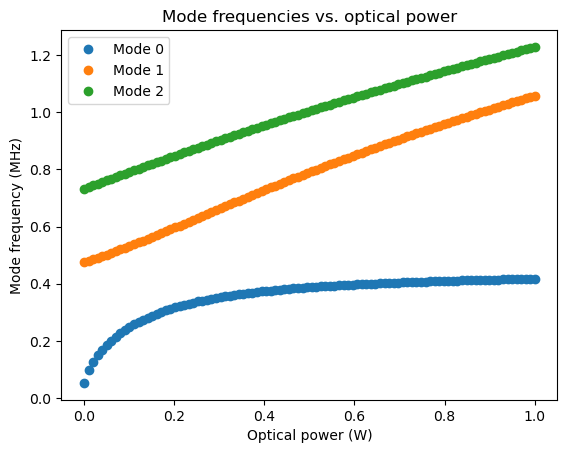

In [3]:
plt.plot(P_opt, [mode["frequencies"][0]/1e6 for mode in Modes], 'o',label="Mode 0")
plt.plot(P_opt, [mode["frequencies"][1]/1e6 for mode in Modes], 'o',label="Mode 1")
plt.plot(P_opt, [mode["frequencies"][2]/1e6 for mode in Modes], 'o',label="Mode 2")

plt.xlabel("Optical power (W)")
plt.ylabel("Mode frequency (MHz)")
plt.title("Mode frequencies vs. optical power")
plt.legend()
plt.show()

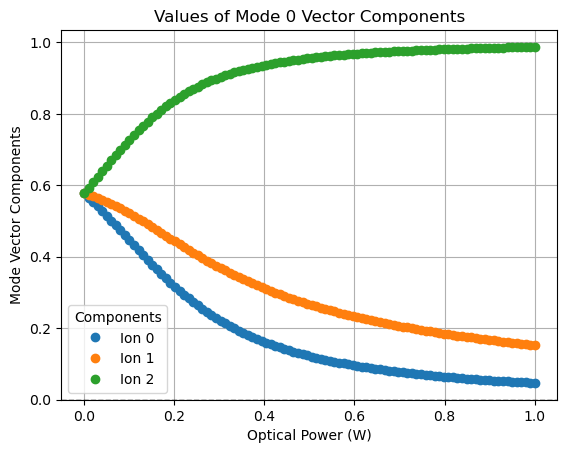

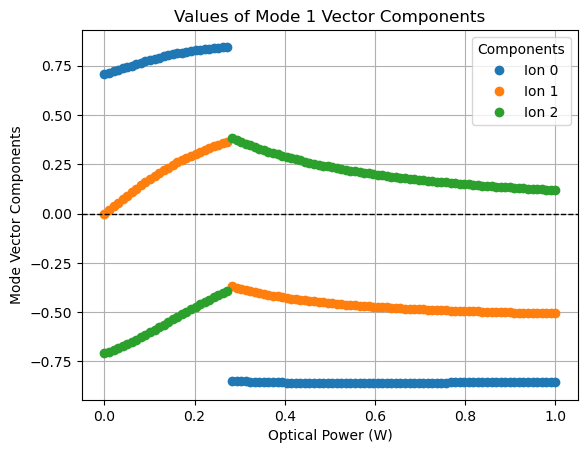

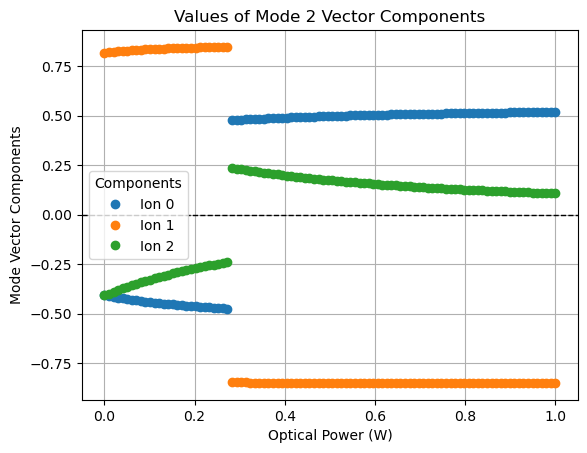

In [4]:
for mode_index in range(N):  # Modes are indexed from 0 to N-1
    # Extract the vector components for the current mode across all powers
    vector_components = [mode_entry['vectors'][mode_index] for mode_entry in Modes]

    plt.figure()  # Create a new figure for each mode
    for component_index in range(len(vector_components[0])):  # Each vector has multiple components
        # Compute the absolute value of the component across all powers
        component_values = [vec[component_index] for vec in vector_components]
        plt.plot(P_opt, component_values, 'o',label=f'Ion {component_index}', linewidth=2)

    # Customize each plot
    plt.xlabel('Optical Power (W)')
    plt.ylabel('Mode Vector Components')
    plt.title(f'Values of Mode {mode_index} Vector Components')
    #plt.xlim(0.2,0.4)
    plt.legend(title='Components')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
    plt.grid(True)
    plt.show()

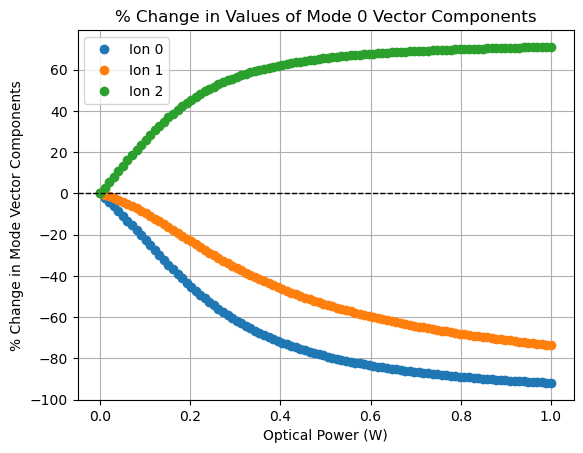

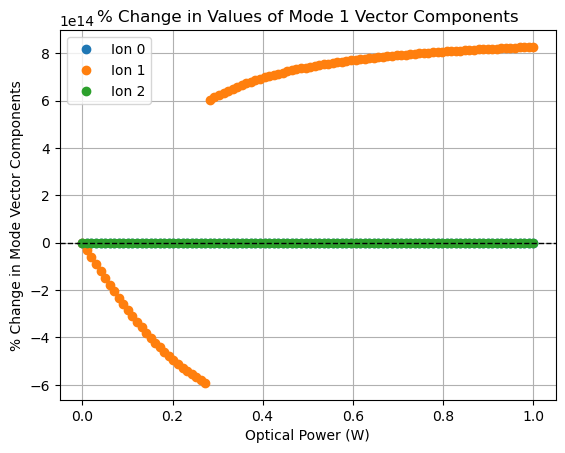

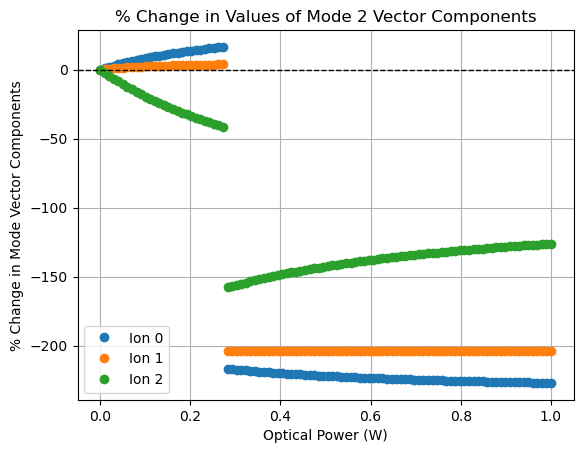

In [5]:
for mode_index in range(N):  # Modes are indexed from 0 to N-1
    # Extract the vector components for the current mode across all powers
    vector_components = [mode_entry['vectors'][mode_index] for mode_entry in Modes]

    plt.figure()  # Create a new figure for each mode
    baseline_vector = vector_components[0]  # Baseline vector at P_opt[0]

    for component_index in range(len(baseline_vector)):  # Each vector has multiple components
        # Calculate percentage change for the current component across all powers
        component_values = [
            100 * (vec[component_index] - baseline_vector[component_index]) / baseline_vector[component_index]
            if baseline_vector[component_index] != 0 else 0  # Avoid division by zero
            for vec in vector_components
        ]
        
        # Plot percentage change for the current component
        plt.plot(P_opt, component_values,'o', label=f'Ion {component_index}', linewidth=2)

    # Customize each plot
    plt.xlabel('Optical Power (W)')
    plt.ylabel('% Change in Mode Vector Components')
    plt.title(f'% Change in Values of Mode {mode_index} Vector Components')
    plt.legend()
    plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
    plt.grid(True)
    plt.show()


In [6]:
P_opt = np.linspace(0,1,100) #going from 0 to 1 W 
w_rf_r =1* 1e6
w_rf_a = w_rf_r / 4
omega_rf_axial = w_rf_a * 2 * pi
displacement = 1e-6
beam_waist_fixed = 5e-6

#print(P_opt)
N = 3
tweezed_ions = [0,1]
ionspacing = ion_spacing(N,omega_rf_axial)
print(ionspacing)
# Initialize a list to store data: each element corresponds to a power
Modes = []

# Iterate over optical powers
for j in range(len(P_opt)):
    # Calculate tweezer radial frequency and equilibrium positions
    omega_tw_radial = 2 * np.pi * tweezer_optical_potential_to_trap_frequency(
        tweezer_wavelength, linewidths, omega_res, P_opt[j], beam_waist_fixed, m
    )[0]
    ueq = ion_spacing_2_tweezers(pot_derivative_with_2tweeze,ionspacing,omega_rf_axial, 
                                 omega_tw_radial, tweezed_ions[0],tweezed_ions[1], displacement,displacement)[0]

    # Get modes for the tweezed system (both ions tweezed simultaneously)
    mode_data = physical_params_to_axial_mode_vectors(
        N, ueq, tweezed_ions, tweezer_wavelength, linewidths, omega_res, w_rf_a, w_rf_r, P_opt[j], beam_waist_fixed, m
    )

    # Save both frequencies and mode vectors
    Modes.append({
        "frequencies": [rm[0] for rm in mode_data],  # Extract frequencies
        "vectors": [rm[1] for rm in mode_data]       # Extract mode vectors
    })

# Print the structure of Modes for verification
print(f"Modes structure (frequencies and vectors per power):")
for idx, mode_entry in enumerate(Modes[:5]):  # Display the first 5 power entries
    print(f"P_opt[{idx}] Frequencies: {mode_entry['frequencies']}")
    print(f"P_opt[{idx}] Vectors: {mode_entry['vectors']}")

[array([-1.20765590e-05,  2.02516415e-19,  1.20765590e-05]), [1.2076558969118422e-05, 1.2076558969117814e-05]]
Modes structure (frequencies and vectors per power):
P_opt[0] Frequencies: [39788.735772973676, 279141.3802471431, 486935.6271659529]
P_opt[0] Vectors: [array([-0.57735027, -0.57735027, -0.57735027]), array([ 0.79687721, -0.24436061, -0.55251661]), array([ 0.17791395, -0.77907288,  0.60115894])]
P_opt[1] Frequencies: [39926.539746111914, 145440.1913498406, 346786.30426506954]
P_opt[1] Vectors: [array([0.57717246, 0.57720494, 0.57767328]), array([-0.45655738, -0.35842882,  0.81429979]), array([-0.67707261,  0.73373241, -0.05665193])]
P_opt[2] Frequencies: [40063.79623352281, 146910.4318608827, 348713.3862104781]
P_opt[2] Vectors: [array([0.57700163, 0.57706607, 0.57798258]), array([-0.45750346, -0.35785958,  0.81401911]), array([-0.67657941,  0.73411938, -0.05752416])]
P_opt[3] Frequencies: [40200.55986801527, 158565.3613093631, 351180.18296113616]
P_opt[3] Vectors: [array([0.5

/Users/ritika/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


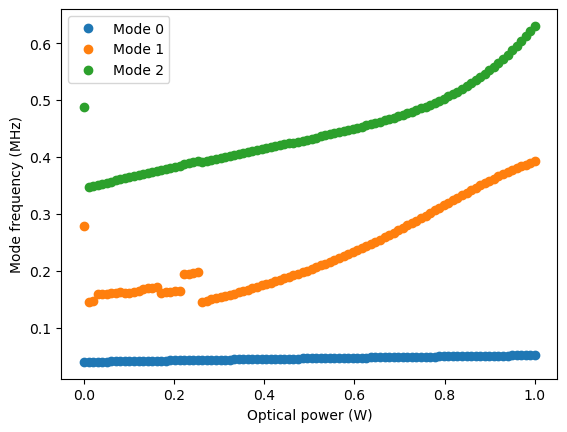

In [7]:
plt.plot(P_opt, [mode["frequencies"][0]/1e6 for mode in Modes], 'o',label="Mode 0")
plt.plot(P_opt, [mode["frequencies"][1]/1e6 for mode in Modes], 'o',label="Mode 1")
plt.plot(P_opt, [mode["frequencies"][2]/1e6 for mode in Modes], 'o',label="Mode 2")

plt.xlabel("Optical power (W)")
plt.ylabel("Mode frequency (MHz)")
plt.legend()
plt.show()

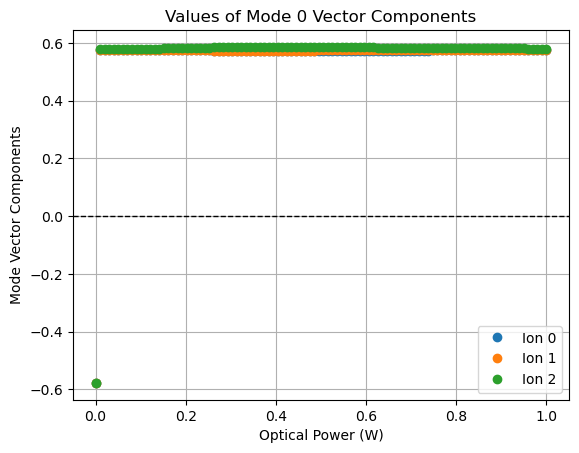

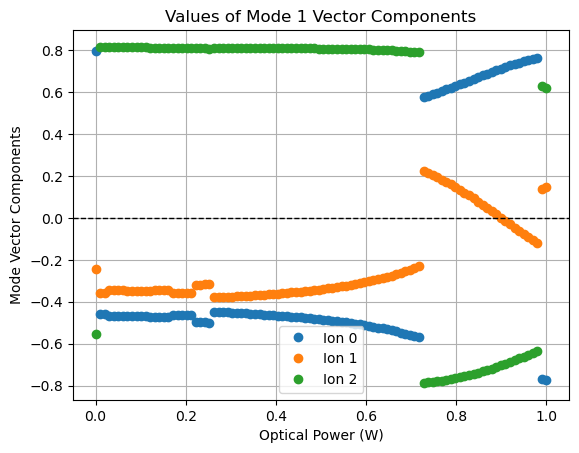

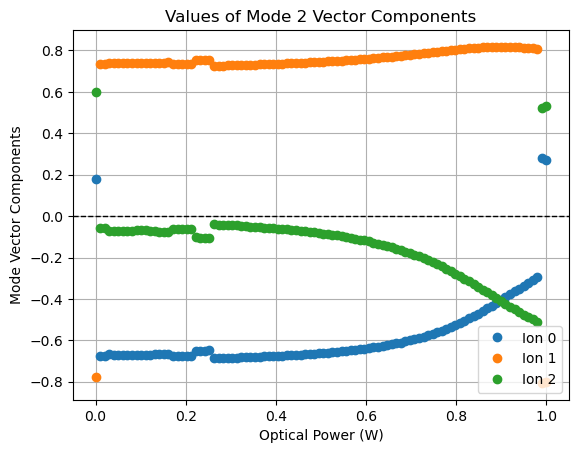

In [8]:
for mode_index in range(N):  # Modes are indexed from 0 to N-1
    # Extract the vector components for the current mode across all powers
    vector_components = [mode_entry['vectors'][mode_index] for mode_entry in Modes]

    plt.figure()  # Create a new figure for each mode
    for component_index in range(len(vector_components[0])):  # Each vector has multiple components
        # Compute the absolute value of the component across all powers
        component_values = [vec[component_index] for vec in vector_components]
        plt.plot(P_opt, component_values, 'o',label=f'Ion {component_index}', linewidth=2)

    # Customize each plot
    plt.xlabel('Optical Power (W)')
    plt.ylabel('Mode Vector Components')
    plt.title(f'Values of Mode {mode_index} Vector Components')
    #plt.xlim(0.2,0.4)
    plt.legend()
    plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
    plt.grid(True)
    plt.show()

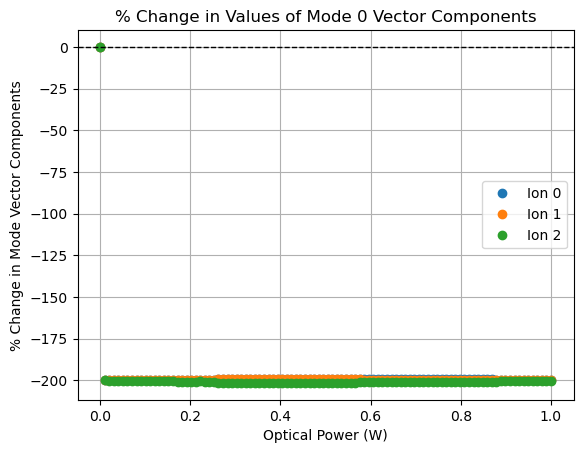

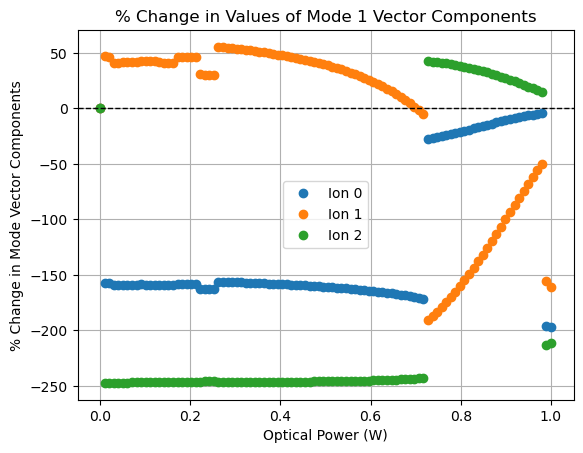

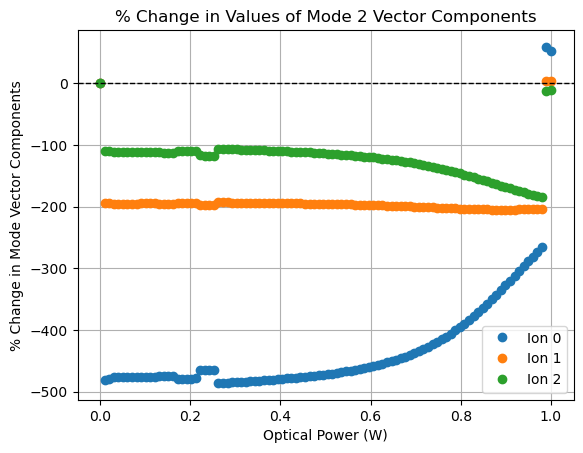

In [9]:
for mode_index in range(N):  # Modes are indexed from 0 to N-1
    # Extract the vector components for the current mode across all powers
    vector_components = [mode_entry['vectors'][mode_index] for mode_entry in Modes]

    plt.figure()  # Create a new figure for each mode
    baseline_vector = vector_components[0]  # Baseline vector at P_opt[0]

    for component_index in range(len(baseline_vector)):  # Each vector has multiple components
        # Calculate percentage change for the current component across all powers
        component_values = [
            100 * (vec[component_index] - baseline_vector[component_index]) / baseline_vector[component_index]
            if baseline_vector[component_index] != 0 else 0  # Avoid division by zero
            for vec in vector_components
        ]
        
        # Plot percentage change for the current component
        plt.plot(P_opt, component_values, 'o',label=f'Ion {component_index}', linewidth=2)

    # Customize each plot
    plt.xlabel('Optical Power (W)')
    plt.ylabel('% Change in Mode Vector Components')
    plt.title(f'% Change in Values of Mode {mode_index} Vector Components')
    plt.legend()
    plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
    plt.grid(True)
    plt.show()


In [10]:
#test